In [2]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from geomloss import SamplesLoss

# Custom library
sys.path.insert(0, "../")
from utils import class_sampler, grid_plot, fix_seed
from models.pretrained import MnistALI, MnistClassifier
import schedulers
from schedulers import *
from constraints import *
from objectives import *
from distances import *
from methods import *
from projections import *

# Load models
device = 'cuda'
epsilon = 0.3
generator = MnistALI()
classifier = MnistClassifier().eval()
combined = lambda z: classifier(generator.decode(z))


# Sample data
torch.manual_seed(1)
z_data = torch.cat([class_sampler(classifier, generator, c, samples=2, threshold=0.99, device=device) for c in range(10)])
y_data = torch.tensor([[c]*2 for c in range(10)], device=device).flatten()
x_data = generator.decode(z_data)
z0 = z_data.clone()
z = torch.roll(z0.clone(), 2, dims=0)

C:\Users\cerma\anaconda3\envs\ml\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### No attack

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9],
       device='cuda:0')


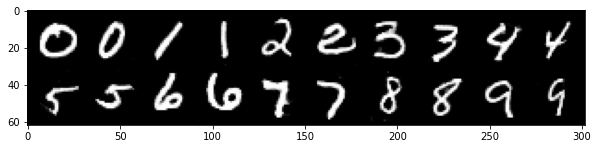

In [3]:
print(classifier(x_data).argmax(1))
grid_plot(x_data, nrows=10)

# 1. Image attacks

### FGSM on images
- Untargeted attack with l-inf epsilon = 0.3
- Clip images to pixel range

tensor([2, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, 8, 8, 8],
       device='cuda:0')


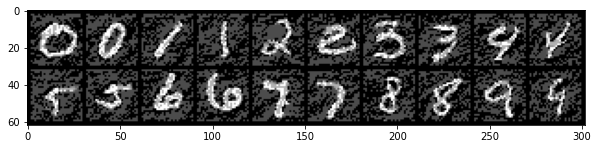

In [6]:
fix_seed()
x_per = fgsm(x_data, y_data, classifier, epsilon=epsilon)

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

### PGD on images
#### Untargeted,
- l-inf, 50 iterations

tensor([2, 2, 8, 8, 8, 9, 5, 9, 9, 8, 8, 3, 9, 8, 8, 8, 3, 6, 8, 4],
       device='cuda:0')


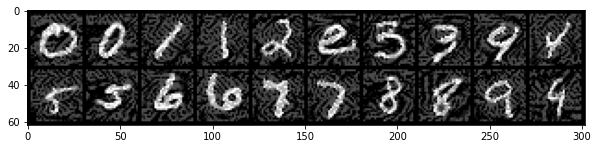

In [26]:
fix_seed()
objective = Objective(y_data, nn.CrossEntropyLoss(), classifier, targeted=False)
projection = ProjectionLinf(epsilon)
x_per = projected_gd(x_data, objective, projection, grad_norm='sign', steps=50, step_size=0.1, clip=(0, 1))

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

#### Targeted
- l-inf, 50 iterations

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')


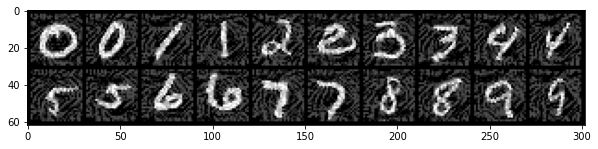

In [27]:
fix_seed()
objective = Objective(y_data*0, nn.CrossEntropyLoss(), classifier, targeted=True)
projection = ProjectionLinf(epsilon)
x_per = projected_gd(x_data, objective, projection, grad_norm='sign', steps=50, step_size=0.1, clip=(0, 1))

print(classifier(x_per).argmax(1))
grid_plot(x_per, nrows=10)

### Compare projection on l2 ball basic vs binary search

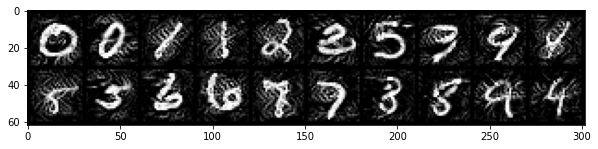

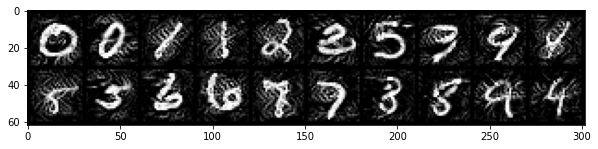

tensor(0.0007, device='cuda:0', grad_fn=<SumBackward0>)


In [28]:
fix_seed()
objective = Objective(y_data, nn.CrossEntropyLoss(), classifier, targeted=False)

# Projection using norm
projection = ProjectionL2(5.0)
x_per1 = projected_gd(x_data, objective, projection, grad_norm='l2', steps=10, step_size=1.0, clip=(0, 1))

# Projection using binary search
constraint = ConstraintDistance(x_data, L2(), 5.0)
projection = ProjectionBinarySearch(constraint, threshold=0.00001)
x_per2 = projected_gd(x_data, objective, projection, grad_norm='l2', steps=10, step_size=1.0, clip=(0, 1))

grid_plot(x_per1, nrows=10)
grid_plot(x_per2, nrows=10)
print((x_per1 - x_per2).abs().sum())

# 2. Latent attacks

## 2.1 Minimize model loss
- distance is constraint

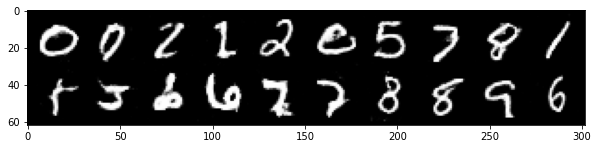

tensor([0, 0, 2, 1, 2, 0, 5, 7, 8, 1, 5, 5, 6, 6, 2, 7, 8, 8, 9, 6],
       device='cuda:0')

In [29]:
fix_seed()

# Minimize losss (crossnetropy) such that ||x0-x||2 < epsilon
distance = L2(Decoded(generator))
constraint = ConstraintDistance(z_data, distance, 5.0)
projection = ProjectionBinarySearch(constraint, threshold=0.001)
objective = Objective(y_data, nn.CrossEntropyLoss(), combined, targeted=False)
z_per = projected_gd(z_data, objective, projection, grad_norm='sign', steps=20, step_size=0.1, clip=None)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

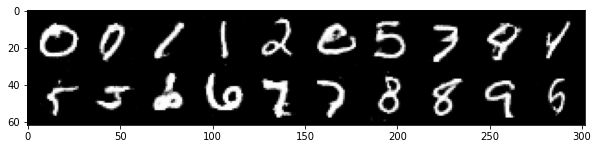

tensor([0, 0, 1, 1, 2, 0, 5, 3, 8, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 5],
       device='cuda:0')

In [30]:
fix_seed()

# Minimize losss (crossnetropy) such that WD(x0, x1) < epsilon
distance = GeomLoss(SamplesLoss("sinkhorn", p=1, blur=0.1, scaling=0.5), DecodedDistribution(generator))
constraint = ConstraintDistance(z_data, distance, 0.0025)
projection = ProjectionBinarySearch(constraint, threshold=0.0005)
objective = Objective(y_data, nn.CrossEntropyLoss(), combined, targeted=False)
z_per = projected_gd(z_data, objective, projection, grad_norm='l2', steps=20, step_size=0.1, clip=None)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

### Projection using binary search

- No objective, simplest way to satisfy constraint.

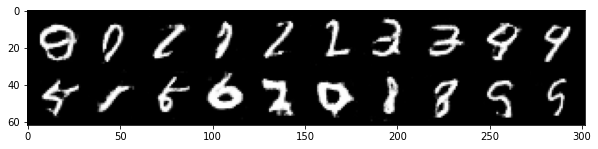

tensor([[9, 7, 2, 7, 1, 1, 2, 2, 8, 9, 4, 1, 5, 0, 2, 0, 1, 3, 5, 5],
        [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]],
       device='cuda:0')


In [15]:
fix_seed()

z_per = bisection_method(z0, z, combined, threshold=1e-3)
grid_plot(generator.decode(z_per), nrows=10)
print(combined(z_per).topk(2)[1].T)

## 2.2 Minimize distance
- Misclassification is constraint

In [11]:
import distances
from methods import calculate_gradients

### Pentaly method

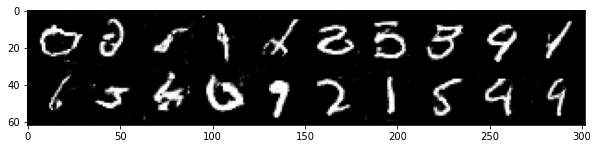

tensor([5, 2, 5, 4, 4, 3, 5, 5, 9, 1, 6, 3, 5, 0, 9, 2, 1, 5, 4, 4],
       device='cuda:0')

In [3]:
fix_seed(1)

penm = PenaltyPopMethod(
    distance = "l2",
    constraint = "misclassify",
    rho = {"scheduler": "SchedulerStep", "params": {"initial": 10e8, "gamma": 1, "n":10}},
    xi = {"scheduler": "SchedulerExponential", "params": {"initial": 1, "gamma": 0.01}},
    grad_norm = "l2",
    iters = 100
)
z_per = penm(z0, combined, generator)

nan = z_per.isnan().all(1).flatten()
grid_plot(generator.decode(z_per[~nan]), nrows=10)
combined(z_per[~nan]).argmax(1)

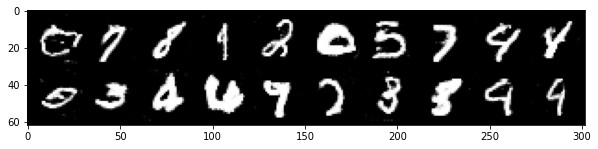

tensor([5, 7, 8, 4, 8, 0, 5, 7, 9, 8, 3, 3, 4, 4, 9, 2, 3, 3, 4, 4],
       device='cuda:0')

In [13]:
fix_seed(1)

penm = PenaltyPopMethod(
    distance = "wd",
    distance_args = {"loss": "sinkhorn", "p":1, "blur":0.1, "scaling":0.5},
    constraint = "misclassify",
    rho = {"scheduler": "SchedulerStep", "params": {"initial": 10e8, "gamma": 1, "n":10}},
    xi = {"scheduler": "SchedulerExponential", "params": {"initial": 1, "gamma": 0.01}},
    grad_norm = 'l2',
    iters = 100
)
z_per = penm(z0, combined, generator)

nan = z_per.isnan().all(1).flatten()
grid_plot(generator.decode(z_per[~nan]), nrows=10)
combined(z_per[~nan]).argmax(1)

### Projection method

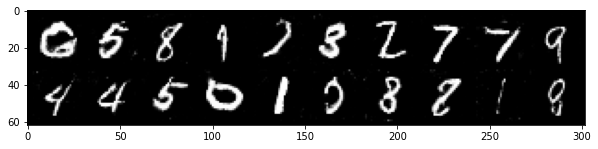

tensor([6, 5, 8, 4, 1, 3, 2, 7, 7, 9, 4, 4, 5, 0, 1, 2, 3, 2, 1, 8],
       device='cuda:0')

In [14]:
fix_seed(1)

projm = ProjectionMethod(
    distance = 'l2',
    constraint = 'misclassify',
    xi_c = {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    xi_o = {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    grad_norm_c = 'l2',
    grad_norm_o = 'l2',
    threshold = 0.001,
    iters = 150
)
z_per = projm(z0, z, combined, generator)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

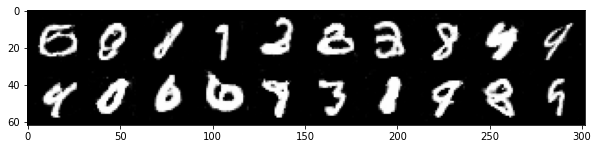

tensor([5, 8, 8, 7, 3, 8, 2, 8, 9, 9, 4, 0, 0, 0, 8, 3, 1, 9, 8, 5],
       device='cuda:0')

In [10]:
fix_seed(1)

projm = ProjectionMethod(
    distance = "wd",
    distance_args = {"loss": "sinkhorn", "p":1, "blur":0.1, "scaling":0.5},
    constraint = 'misclassify',
    xi_c = {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    xi_o = {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    grad_norm_c = 'l2',
    grad_norm_o = 'l2',
    threshold = 0.001,
    iters = 150
)
z_per = projm(z0, z, combined, generator)

grid_plot(generator.decode(z_per), nrows=10)
combined(z_per).argmax(1)

# 3. Partial Generators

In [3]:
params_wd = {
    "distance": "wd",
    "distance_args": {"loss": "sinkhorn", "p":1, "blur":0.1, "scaling":0.5},
    "constraint": 'misclassify',
    "xi_c": {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    "xi_o": {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    "grad_norm_c": 'l2',
    "grad_norm_o": 'l2',
    'threshold': 0.001,
    "iters": 150
}

params_l2 = {
    "distance": "l2",
    "constraint": 'misclassify',
    "xi_c": {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    "xi_o": {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    "grad_norm_c": 'l2',
    "grad_norm_o": 'l2',
    'threshold': 0.001,
    "iters": 150
}

### Level 0 - Generator

In [12]:
gp_generator = MnistALI(0)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

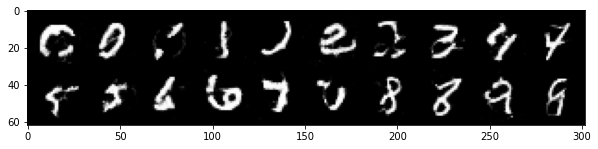

tensor([9, 9, 5, 3, 1, 3, 2, 2, 7, 7, 4, 3, 5, 3, 3, 3, 3, 3, 2, 8],
       device='cuda:0')

In [27]:
fix_seed(1)
projm = ProjectionMethod(**params_l2)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
gp_combined(z_per).argmax(1)

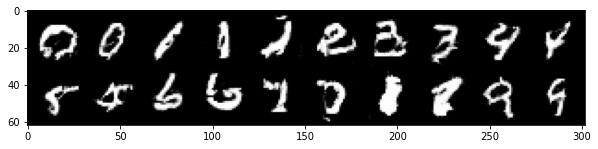

tensor([9, 9, 6, 0, 1, 8, 2, 2, 9, 8, 8, 4, 5, 5, 1, 0, 1, 2, 8, 8],
       device='cuda:0')

In [14]:
fix_seed(1)
projm = ProjectionMethod(**params_wd)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
gp_combined(z_per).argmax(1)

### Level 1 - Generator

In [30]:
gp_generator = MnistALI(1)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

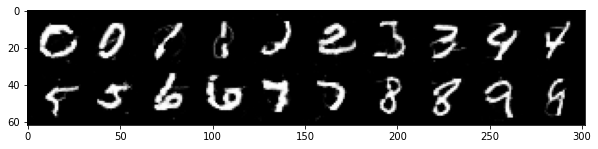

tensor([5, 9, 3, 0, 1, 3, 1, 2, 9, 7, 4, 3, 5, 5, 3, 3, 3, 3, 7, 8],
       device='cuda:0')

In [31]:
fix_seed(1)
projm = ProjectionMethod(**params_l2)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
gp_combined(z_per).argmax(1)

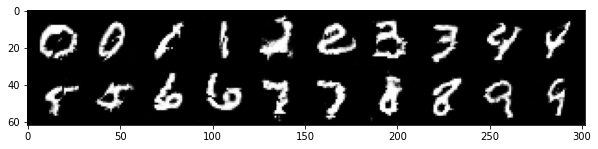

tensor([9, 9, 0, 6, 1, 8, 2, 7, 9, 8, 4, 4, 5, 5, 3, 3, 1, 2, 3, 8],
       device='cuda:0')

In [32]:
fix_seed(1)
projm = ProjectionMethod(**params_wd)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
gp_combined(z_per).argmax(1)

### Level 2 - Generator

In [40]:
gp_generator = MnistALI(2)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

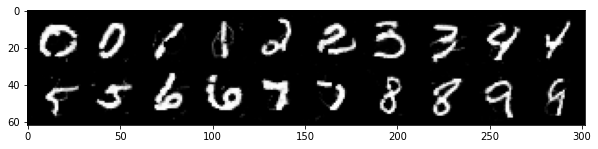

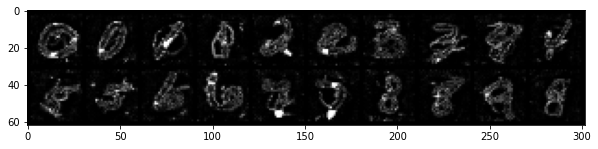

Wall time: 3min 39s


In [45]:
%%time
fix_seed(1)
projm = ProjectionMethod(**params_l2)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
diff = gp_generator.decode(z_per) - gp_generator.decode(v0)
grid_plot(diff.abs()**(1/2), nrows=10)

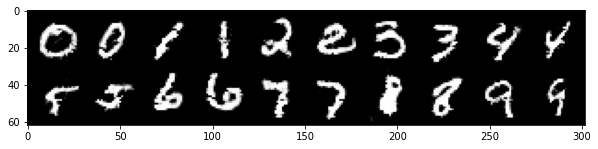

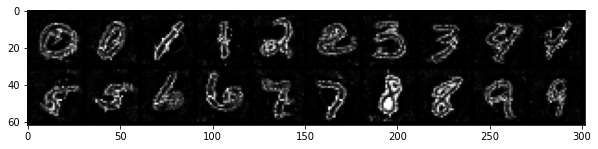

Wall time: 4min 1s


tensor([9, 9, 5, 8, 3, 8, 5, 7, 8, 8, 4, 7, 5, 5, 3, 3, 1, 2, 8, 8],
       device='cuda:0')

In [44]:
%%time
fix_seed(1)
projm = ProjectionMethod(**params_wd)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)
diff = gp_generator.decode(z_per) - gp_generator.decode(v0)
grid_plot(diff.abs()**(1/2), nrows=10)

### Level 3 - Generator

In [3]:
gp_generator = MnistALI(3)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

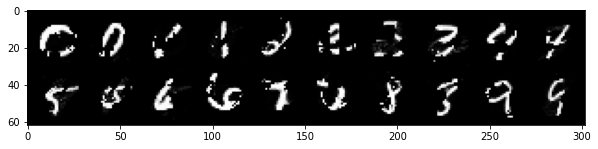

Wall time: 1min 52s


In [4]:
%%time
fix_seed(1)
projm = ProjectionMethod(**params_l2)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)

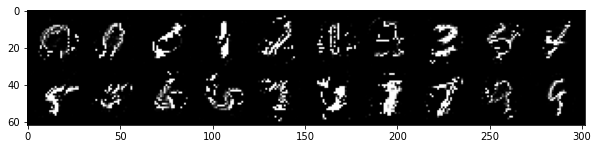

Wall time: 2min 1s


In [54]:
%%time
fix_seed(1)
projm = ProjectionMethod(**params_wd)
z_per = projm(v0, v, gp_combined, gp_generator)

grid_plot(gp_generator.decode(z_per), nrows=10)

## Targeted attack

In [9]:
target_labels = combined(z).argmax(1)

gp_generator = MnistALI(2)
gp_combined = lambda z: classifier(gp_generator.decode(z))

v0 = gp_generator.encode(z0)
v = gp_generator.encode(z)

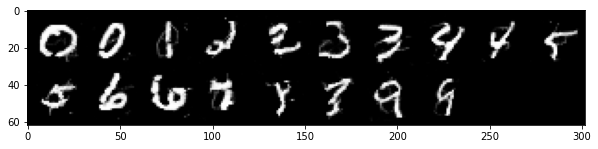

Wall time: 3min 35s


tensor([9, 9, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 8], device='cuda:0')

In [10]:
%%time
fix_seed(1)

params_l2 = {
    "distance": "l2",
    "constraint": 'targeted',
    "xi_c": {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    "xi_o": {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    "grad_norm_c": 'l2',
    "grad_norm_o": 'l2',
    'threshold': 0.001,
    "iters": 150
}


projm = ProjectionMethod(**params_l2)
z_per = projm(v0, v, gp_combined, gp_generator, target=target_labels)

nan = torch.isnan(z_per).view(z_per.shape[0], -1).any(dim=1)
grid_plot(gp_generator.decode(z_per[~nan]), nrows=10)
gp_combined(z_per[~nan]).argmax(1)

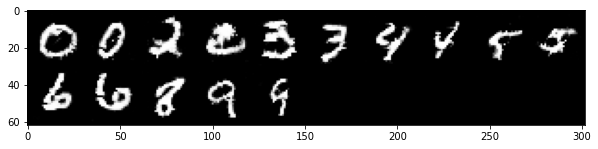

Wall time: 3min 42s


tensor([9, 9, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 7, 8, 8], device='cuda:0')

In [11]:
%%time
fix_seed(1)

params_wd = {
    'distance': "wd",
    'distance_args': {"loss": "sinkhorn", "p":1, "blur":0.1, "scaling":0.5},
    "constraint": 'targeted',
    "xi_c": {'scheduler': 'SchedulerPower', 'params': {'initial': 1, 'power': -0.5}},
    "xi_o": {'scheduler': 'SchedulerConstant', 'params': {'alpha': 1}},
    "grad_norm_c": 'l2',
    "grad_norm_o": 'l2',
    'threshold': 0.001,
    "iters": 150
}


projm = ProjectionMethod(**params_wd)
z_per = projm(v0, v, gp_combined, gp_generator, target=target_labels)

nan = torch.isnan(z_per).view(z_per.shape[0], -1).any(dim=1)
grid_plot(gp_generator.decode(z_per[~nan]), nrows=10)
gp_combined(z_per[~nan]).argmax(1)

### Targeted PenaltyPop


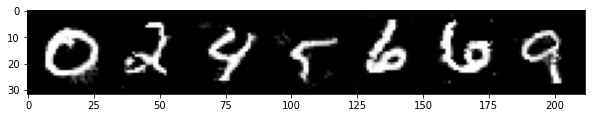

tensor([9, 1, 3, 4, 5, 5, 8], device='cuda:0')

In [12]:
fix_seed(1)

penm = PenaltyPopMethod(
    distance = "l2",
    constraint = "targeted",
    rho = {"scheduler": "SchedulerStep", "params": {"initial": 10e8, "gamma": 1, "n":10}},
    xi = {"scheduler": "SchedulerExponential", "params": {"initial": 1, "gamma": 0.01}},
    grad_norm = 'l2',
    iters = 1000,
    max_unchanged = 200
)
z_per = penm(v0, gp_combined, gp_generator, target=target_labels)

nan = torch.isnan(z_per).view(z_per.shape[0], -1).any(dim=1)
grid_plot(gp_generator.decode(z_per[~nan]), nrows=10)
gp_combined(z_per[~nan]).argmax(1)

# Foolbox pixel attack

In [2]:
import foolbox as fb
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox import Misclassification

In [16]:
attack = fb.attacks.L2CarliniWagnerAttack()
fmodel = fb.PyTorchModel(classifier, bounds=(0, 1))
crit = Misclassification(y_data)
images, = ep.astensors(x_data.detach())

_, advs, success = attack(model=fmodel, inputs=images, criterion=crit, epsilons=[1.0])
x_adv = advs[-1].raw

In [17]:
y_data

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9],
       device='cuda:0')

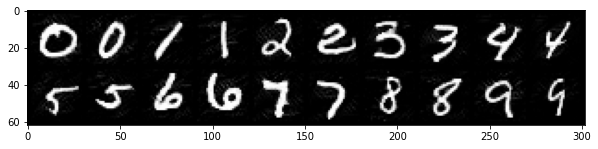

In [18]:
grid_plot(x_adv, nrows=10, figsize=(10, 20))

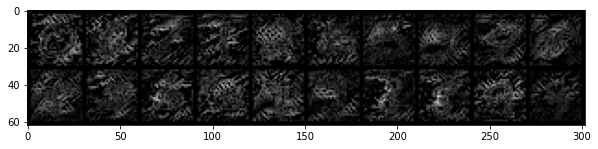

In [19]:
diff = (x_adv - x_data).abs()**(1/2)
grid_plot(diff, nrows=10)

In [20]:
classifier(x_adv).argmax(1)

tensor([0, 0, 7, 7, 8, 3, 5, 9, 9, 8, 8, 3, 5, 8, 1, 9, 3, 8, 9, 4],
       device='cuda:0')